In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

## Read data

In [7]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess data

In [8]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

cat_cols = ['Sex']
target = 'Rings'
continuous_cols = [col for col in train.columns if col not in cat_cols + [target]]

train[continuous_cols] = scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = scaler.transform(test[continuous_cols])

X = train.drop(columns=['Rings'], axis=1).values
y = train['Rings'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 100
# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define network

In [9]:
class TabTransformerModel(nn.Module):
    """
    TabTransformer model for regression.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        """
        Initialize the TabTransformer model.
        
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Hidden dimension of the transformer.
            num_layers (int): Number of transformer encoder layers.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout probability.
        """
        super(TabTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, input_dim + 1, hidden_dim))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True),
            num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Perform forward pass through the TabTransformer model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Model output.
        """
        x = self.embedding(x)
        cls_tokens = self.cls_token.repeat(x.size(0), 1, 1)
        x = torch.cat([cls_tokens, x.unsqueeze(1)], dim=1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        x = self.fc(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
# Define hyperparameters
input_dim = X_train_tensor.shape[1]  # Number of features
params = {'hidden_dim': 128, 'num_heads': 2, 
          'num_layers': 1, 
          'dropout': 0.3273933055446089
         }

# Initialize the model
model = FTTransformerModel(input_dim, **params).to(device)

## Define training loop

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 5.5399, Val Loss: 4.4966


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 4.1536, Val Loss: 8.3228


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 4.0940, Val Loss: 7.8022


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 3.9591, Val Loss: 4.3460


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 3.9999, Val Loss: 5.6975


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 3.9705, Val Loss: 3.8019


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 3.7865, Val Loss: 4.9489


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 3.7778, Val Loss: 4.8046


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

Early stopping at epoch 9


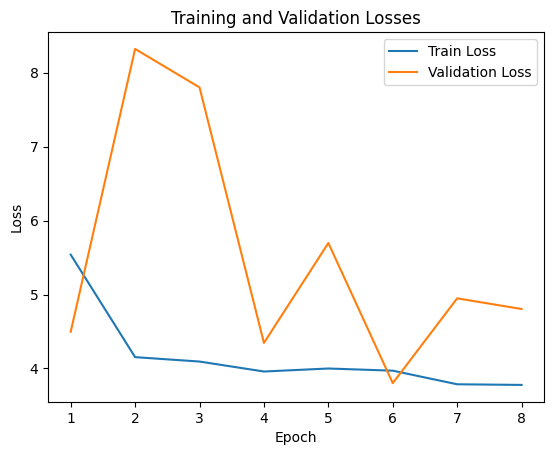

In [14]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize best_val_loss here
best_model_state = None
patience_counter = 0
early_stopping_patience = 3  # Define the patience for early stopping


EPOCHS = 20
initial_lr = 0.004  # Start with a small learning rate
lr_step_size = 6   # Update the learning rate every 6 epochs
lr_gamma = 0.1      # Multiply the learning rate by 0.1 every lr_step_size epochs
criterion = nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

train_losses = []
val_losses = []

for epoch in trange(EPOCHS):
    # Training phase
    avg_train_loss = []
    model.train()  # Set model to training mode
    for i, (image, mask) in enumerate(tqdm(train_loader)):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        mask = mask.view(-1, 1) 
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        avg_train_loss.append(loss.item())

    avg_train_loss = np.mean(avg_train_loss)

    # Validation phase
    avg_val_loss = []
    model.eval()  # Set model to evaluation mode
    for j, (image, mask) in enumerate(tqdm(val_loader)):
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            output = model(image)
            mask = mask.view(-1, 1)
            loss = criterion(output, mask)
            avg_val_loss.append(loss.item())

    avg_val_loss = np.mean(avg_val_loss)

     # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Apply learning rate scheduling
    scheduler.step()

    # Append the losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

# Plot the losses
plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## Inference

In [27]:
# Inference

test_tensor = torch.tensor(test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    model.eval()
    predictions = model(test_tensor)
predictions

tensor([[ 9.7133],
        [ 9.6166],
        [10.1554],
        ...,
        [12.7128],
        [13.0745],
        [ 8.5461]], device='cuda:0')

## Hyperparameter tune 

In [6]:
def train_model(params):
    """
    Train the FT-Transformer model with the given hyperparameters.
    
    Args:
        params (dict): Hyperparameters for the model.
        
    Returns:
        float: Average validation RMSE across folds.
    """
    # Unpack the hyperparameters
    input_dim = X_train_tensor.shape[1]
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    num_heads = params['num_heads']
    dropout = params['dropout']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    early_stopping_patience = params['early_stopping_patience']
    
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the FT-Transformer model
    model = TabTransformerModel(input_dim, hidden_dim, num_layers, num_heads, dropout).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create KFold cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_val_rmse_folds = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold [{fold+1}/3]")

        # Create train and validation datasets using the indices
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset = torch.utils.data.TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

        # Create data loaders for train and validation datasets
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        # Initialize variables for early stopping
        best_val_rmse = float('inf')  # Initialize best_val_rmse here
        best_model_state = None
        patience_counter = 0

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            model.train()
            
            # Iterate over the training batches
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_predictions = []
            val_targets = []
            
            # Iterate over the validation batches
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_predictions.append(outputs.squeeze().cpu().numpy())
                    val_targets.append(batch_y.cpu().numpy())
            
            # Concatenate the validation predictions and targets
            val_predictions = np.concatenate(val_predictions)
            val_targets = np.concatenate(val_targets)
            
            # Calculate validation RMSE
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation RMSE: {val_rmse:.4f}")
            
            # Check for early stopping
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Store the best validation RMSE for the current fold
        best_val_rmse_folds.append(best_val_rmse)
        
        # Load the best model state for the current fold
        model.load_state_dict(best_model_state)
    
    # Calculate the average validation RMSE across all folds
    avg_val_rmse = np.mean(best_val_rmse_folds)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")
    
    return avg_val_rmse

def objective(trial):
    """
    Objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        
    Returns:
        float: Average validation RMSE.
    """
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256, step=16)
    num_heads = trial.suggest_int('num_heads', 2, hidden_dim // 16)
    
    while hidden_dim % num_heads != 0:
        num_heads -= 1
    
    params = {
        'hidden_dim': hidden_dim,
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'num_heads': num_heads,
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'num_epochs': 200,
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'early_stopping_patience': 10
    }
    
    avg_val_rmse = train_model(params)
    
    return avg_val_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(multivariate=True))

# # Optimize the hyperparameters
study.optimize(objective, timeout=3600 * 10)

# # Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)


/opt/conda/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-04-17 09:53:20,783] A new study created in memory with name: no-name-4bd20500-07bc-4851-9d55-4141a05bdfa4


Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.0691
Epoch [2/200], Validation RMSE: 1.9598
Epoch [3/200], Validation RMSE: 2.0541
Epoch [4/200], Validation RMSE: 1.9501
Epoch [5/200], Validation RMSE: 2.0500
Epoch [6/200], Validation RMSE: 2.1124
Epoch [7/200], Validation RMSE: 1.9657
Epoch [8/200], Validation RMSE: 1.9666
Epoch [9/200], Validation RMSE: 1.9595
Epoch [10/200], Validation RMSE: 1.9631
Epoch [11/200], Validation RMSE: 1.9481
Epoch [12/200], Validation RMSE: 2.0426
Epoch [13/200], Validation RMSE: 1.9436
Epoch [14/200], Validation RMSE: 1.9500
Epoch [15/200], Validation RMSE: 1.9825
Epoch [16/200], Validation RMSE: 1.9474
Epoch [17/200], Validation RMSE: 2.0125
Epoch [18/200], Validation RMSE: 2.2631
Epoch [19/200], Validation RMSE: 1.9666
Epoch [20/200], Validation RMSE: 1.9916
Epoch [21/200], Validation RMSE: 1.9800
Epoch [22/200], Validation RMSE: 1.9860
Epoch [23/200], Validation RMSE: 1.9631
Early stopping at epoch 23
Fold [2/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.0408
Epoch [2/200], Validation RMSE: 1.9495
Epoch [3/200], Validation RMSE: 1.9287
Epoch [4/200], Validation RMSE: 2.0170
Epoch [5/200], Validation RMSE: 1.9285
Epoch [6/200], Validation RMSE: 1.9999
Epoch [7/200], Validation RMSE: 1.9977
Epoch [8/200], Validation RMSE: 2.0290
Epoch [9/200], Validation RMSE: 2.0177
Epoch [10/200], Validation RMSE: 1.9994
Epoch [11/200], Validation RMSE: 1.9838
Epoch [12/200], Validation RMSE: 1.9830
Epoch [13/200], Validation RMSE: 1.9848
Epoch [14/200], Validation RMSE: 2.0646
Epoch [15/200], Validation RMSE: 2.0607
Early stopping at epoch 15
Fold [3/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9364
Epoch [2/200], Validation RMSE: 1.9764
Epoch [3/200], Validation RMSE: 1.9687
Epoch [4/200], Validation RMSE: 2.1064
Epoch [5/200], Validation RMSE: 2.1415
Epoch [6/200], Validation RMSE: 1.9165
Epoch [7/200], Validation RMSE: 1.9839
Epoch [8/200], Validation RMSE: 2.0739
Epoch [9/200], Validation RMSE: 1.9817
Epoch [10/200], Validation RMSE: 2.1029
Epoch [11/200], Validation RMSE: 2.0775
Epoch [12/200], Validation RMSE: 2.0295
Epoch [13/200], Validation RMSE: 1.9218
Epoch [14/200], Validation RMSE: 2.1733
Epoch [15/200], Validation RMSE: 2.2080


[I 2024-04-17 10:00:50,534] Trial 0 finished with value: 1.929545283317566 and parameters: {'hidden_dim': 80, 'num_heads': 2, 'num_layers': 1, 'dropout': 0.3054079771160905, 'batch_size': 20, 'learning_rate': 0.009681553086442201}. Best is trial 0 with value: 1.929545283317566.


Epoch [16/200], Validation RMSE: 2.0131
Early stopping at epoch 16
Average Validation RMSE across folds: 1.9295
Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.2336
Epoch [2/200], Validation RMSE: 2.4713
Epoch [3/200], Validation RMSE: 2.3855
Epoch [4/200], Validation RMSE: 2.8217
Epoch [5/200], Validation RMSE: 3.0736
Epoch [6/200], Validation RMSE: 2.4085
Epoch [7/200], Validation RMSE: 2.3997
Epoch [8/200], Validation RMSE: 2.8642
Epoch [9/200], Validation RMSE: 2.2132
Epoch [10/200], Validation RMSE: 2.0966
Epoch [11/200], Validation RMSE: 2.0239
Epoch [12/200], Validation RMSE: 2.1932
Epoch [13/200], Validation RMSE: 2.1720
Epoch [14/200], Validation RMSE: 2.3211
Epoch [15/200], Validation RMSE: 2.6644
Epoch [16/200], Validation RMSE: 2.0570
Epoch [17/200], Validation RMSE: 2.5175
Epoch [18/200], Validation RMSE: 1.9454
Epoch [19/200], Validation RMSE: 1.9592
Epoch [20/200], Validation RMSE: 1.9878
Epoch [21/200], Validation RMSE: 1.9995
Epoch [22/200], Validation RMSE: 1.9602
Epoch [23/200], Validation RMSE: 1.9168
Epoch [24/200], Validation RMSE: 2.0680
Epoch [25/200], Validation RMSE: 2.1864
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9778
Epoch [2/200], Validation RMSE: 1.9696
Epoch [3/200], Validation RMSE: 1.9490
Epoch [4/200], Validation RMSE: 1.9224
Epoch [5/200], Validation RMSE: 1.9793
Epoch [6/200], Validation RMSE: 2.0633
Epoch [7/200], Validation RMSE: 1.9321
Epoch [8/200], Validation RMSE: 1.9895
Epoch [9/200], Validation RMSE: 1.9803
Epoch [10/200], Validation RMSE: 1.9521
Epoch [11/200], Validation RMSE: 2.0228
Epoch [12/200], Validation RMSE: 1.9625
Epoch [13/200], Validation RMSE: 1.9450
Epoch [14/200], Validation RMSE: 1.9843
Early stopping at epoch 14
Fold [3/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9749
Epoch [2/200], Validation RMSE: 1.9378
Epoch [3/200], Validation RMSE: 1.9302
Epoch [4/200], Validation RMSE: 1.9435
Epoch [5/200], Validation RMSE: 1.9298
Epoch [6/200], Validation RMSE: 2.0834
Epoch [7/200], Validation RMSE: 2.0103
Epoch [8/200], Validation RMSE: 2.0366
Epoch [9/200], Validation RMSE: 1.9456
Epoch [10/200], Validation RMSE: 1.9820
Epoch [11/200], Validation RMSE: 1.9327
Epoch [12/200], Validation RMSE: 1.9862
Epoch [13/200], Validation RMSE: 1.9437
Epoch [14/200], Validation RMSE: 2.0223
Epoch [15/200], Validation RMSE: 1.9256
Epoch [16/200], Validation RMSE: 1.9246
Epoch [17/200], Validation RMSE: 2.0029
Epoch [18/200], Validation RMSE: 1.9320
Epoch [19/200], Validation RMSE: 1.9629
Epoch [20/200], Validation RMSE: 1.9646
Epoch [21/200], Validation RMSE: 1.9506
Epoch [22/200], Validation RMSE: 1.9550
Epoch [23/200], Validation RMSE: 1.9227
Epoch [24/200], Validation RMSE: 1.9328
Epoch [25/200], Validation RMSE: 1.9828
Epoch [26

[I 2024-04-17 10:03:42,112] Trial 1 finished with value: 1.9202789068222046 and parameters: {'hidden_dim': 128, 'num_heads': 2, 'num_layers': 1, 'dropout': 0.3273933055446089, 'batch_size': 100, 'learning_rate': 0.0037358329937451713}. Best is trial 1 with value: 1.9202789068222046.


Epoch [37/200], Validation RMSE: 1.9408
Early stopping at epoch 37
Average Validation RMSE across folds: 1.9203
Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.3553
Epoch [2/200], Validation RMSE: 2.0627
Epoch [3/200], Validation RMSE: 2.4521
Epoch [4/200], Validation RMSE: 2.4408
Epoch [5/200], Validation RMSE: 2.5401
Epoch [6/200], Validation RMSE: 2.1885
Epoch [7/200], Validation RMSE: 1.9789
Epoch [8/200], Validation RMSE: 2.2284
Epoch [9/200], Validation RMSE: 2.5950
Epoch [10/200], Validation RMSE: 2.0368
Epoch [11/200], Validation RMSE: 2.1220
Epoch [12/200], Validation RMSE: 1.9542
Epoch [13/200], Validation RMSE: 2.1380
Epoch [14/200], Validation RMSE: 2.0391
Epoch [15/200], Validation RMSE: 2.1220
Epoch [16/200], Validation RMSE: 2.1083
Epoch [17/200], Validation RMSE: 2.1763
Epoch [18/200], Validation RMSE: 1.9457
Epoch [19/200], Validation RMSE: 2.0965
Epoch [20/200], Validation RMSE: 2.0676
Epoch [21/200], Validation RMSE: 2.1203
Epoch [22/200], Validation RMSE: 2.0205
Epoch [23/200], Validation RMSE: 1.9492
Epoch [24/200], Validation RMSE: 2.0948
Epoch [25/200], Validation RMSE: 1.9297
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.0572
Epoch [2/200], Validation RMSE: 2.0464


[W 2024-04-17 10:05:15,508] Trial 2 failed with parameters: {'hidden_dim': 176, 'num_heads': 5, 'num_layers': 1, 'dropout': 0.22873780830791293, 'batch_size': 77, 'learning_rate': 0.001817452752447817} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/2463420578.py", line 140, in objective
    avg_val_rmse = train_model(params)
  File "/tmp/ipykernel_34/2463420578.py", line 63, in train_model
    outputs = model(batch_X)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_34/1829090492.py", line 36, in forward
    x = self.fc(x)

KeyboardInterrupt: 

### Hyperparameter search space is too long but the best results obtained were:
1.892829418182373 and parameters: Trial 1 finished with value: 1.9202789068222046 and parameters: {'hidden_dim': 128, 'num_heads': 2, 'num_layers': 1, 'dropout': 0.3273933055446089, 'batch_size': 100, 'learning_rate': 0.0037358329937451713}. Best is trial 1 with value: 1.9202789068222046.. Best is trial 1 with value: 1.892829418182373.